# pyTorch Intro

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


## Hintergrundinformationen zu Tensoren und Gradienten

Wenn dies auf Ihrem System verfügbar ist, kann PyTorch auch die Grafikkarte (GPU) nutzen um die Berechnungen zu beschleunigen. Ausserdem setzen wir den Random-Number Seed so, dass immer die gleichen Zahlen resultieren. Dies hilft dabei um eine Reproduzierbarkeit zu erreichen.

In [87]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit

Using cpu device


### Tensors

Tensoren sind das PyTorch-Äquivalent zu Numpy-Arrays, mit dem zusätzlichen Vorteil der GPU-Beschleunigung (Grafikkarte).
Der Name "Tensor" ist eine Verallgemeinerung von Konzepten, die Sie bereits kennen. Zum Beispiel ist ein Vektor ein 1-D Tensor und eine Matrix ein 2-D Tensor. Wir werden Tensoren mit verschiedenen Dimensionen verwenden.

Die meisten gängigen Funktionen, die Sie aus Numpy kennen, können auch auf Tensoren angewendet werden. Da Numpy-Arrays und Tensoren sich sehr ähneln, können wir die meisten Tensoren in Numpy-Arrays konvertieren (und umgekehrt), müssen das aber nicht oft tun.

Der folgende Tensor hat zum Beispiel drei Dimensionen und eine Grösse von 2x3x4.

In [88]:
x = torch.Tensor(2, 3, 4)
print(x)
print(x.shape)

tensor([[[ 2.9419e-02,  7.8383e-02,  1.1084e-05,  3.5847e-05],
         [ 2.8544e-02,  4.6422e-03, -1.5805e-02,  9.5983e-02],
         [ 9.3901e-05,  4.0943e-02,  3.1938e-02, -2.6339e-04]],

        [[ 4.2904e-02, -3.1047e-02,  4.7040e-02,  1.0089e-01],
         [ 5.8274e-02, -2.0731e-04, -2.9330e-03, -5.2343e-04],
         [ 2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00]]])
torch.Size([2, 3, 4])



Tensoren können in Numpy-Arrays konvertiert werden, und Numpy-Arrays zurück in Tensoren. Um ein Numpy-Array in einen Tensor umzuwandeln, können wir die Funktion `torch.from_numpy` verwenden:

In [89]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])
PyTorch tensor: tensor([[1, 2],
        [3, 4]])
Numpy array: [[1 2]
 [3 4]]


**Wichtig:** Die Konvertierung von Tensoren zu Numpy erfordert, dass der Tensor auf der CPU und nicht auf der GPU ist. Falls Sie einen Tensor auf der GPU haben, müssen Sie zuerst `.cpu()` auf dem Tensor aufrufen. Daher erhalten Sie eine Zeile wie `np_arr = tensor.cpu().numpy()`.

### Automatische Ableitung (Gradient Berechnung)

Einer der Hauptgründe für die Verwendung von PyTorch in Deep-Learning-Projekten ist, dass wir automatisch **Gradienten/Ableitungen** von Funktionen erhalten können, die wir definieren. Wir werden PyTorch hauptsächlich zur Implementierung neuronaler Netze verwenden. Wenn wir in unseren Neuronalen Netzwerken Parameter haben, die wir lernen möchten, werden diese als **Parameter** oder einfach als **Gewichte** bezeichnet. Diese können von Pytorch automatisch gelernt werden indem die Ableitung berechnet wird.

Manchmal wollen wir aber nicht, dass der Gradient berechnet wird, beziehungsweise dies deaktivieren. Wenn wir zum Beispiel ein Netzwerk evaluieren können wir somit sicherstellen, dass keien Gradienten berechnet werden. Dies können wir mit `with torch.no_grad()` für einen gesamten Codeblock tun:

In [90]:
with torch.no_grad():
    y = x + 2
    print(y)

tensor([[[2.0294, 2.0784, 2.0000, 2.0000],
         [2.0285, 2.0046, 1.9842, 2.0960],
         [2.0001, 2.0409, 2.0319, 1.9997]],

        [[2.0429, 1.9690, 2.0470, 2.1009],
         [2.0583, 1.9998, 1.9971, 1.9995],
         [4.0000, 4.0000, 4.0000, 4.0000]]])


### Optional: Hintergrundinfos zum Dataloader

Die Klasse `torch.utils.data.DataLoader` stellt einen Python-Iterator über einen Datensatz dar und bietet z.B. automatisches Batching. Der Data Loader kommuniziert mit dem Datensatz über die Funktion `__getitem__` und stapelt ihre Ausgaben als Tensoren über die erste Dimension zu einem Batch.

Im Gegensatz zur Dataset-Klasse müssen wir normalerweise keine eigene Data-Loader-Klasse definieren, sondern können einfach ein Objekt davon mit dem Datensatz als Eingabe erstellen. Zusätzlich können wir unseren Data Loader mit den folgenden Eingabeargumenten konfigurieren (nur eine Auswahl, vollständige Liste [hier](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Anzahl der Samples pro Batch
* `shuffle`: Falls True, werden die Daten in zufälliger Reihenfolge zurückgegeben. Dies ist wichtig während des Trainings zur Einführung von Stochastizität.
* `num_workers`: Anzahl der Subprozesse für das Datenladen. Der Standard 0 bedeutet, dass Daten im Hauptprozess geladen werden, was das Training bei Datensätzen mit langen Ladezeiten verlangsamen kann (z.B. grosse Bilder). Mehr Worker werden empfohlen, können aber auf Windows-Computern Probleme verursachen. Bei kleinen Datensätzen wie unserem ist 0 Worker normalerweise schneller.
* `drop_last`: Falls True, wird der letzte Batch verworfen, falls er kleiner als die spezifizierte Batch-Grösse ist. Dies tritt auf, wenn die Datensatzgrösse nicht ein Vielfaches der Batch-Grösse ist. Nur möglicherweise hilfreich während des Trainings zur Konsistenz der Batch-Grösse.

Unten erstellen wir einen einfachen Data Loader mit einem gegebenen Dataset.

In [91]:
# Wir erstellen einen Regressionsdatensatz aus sklearn in einen DataLoader von pytorch
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)
print(X.shape, y.shape)

dataloader = DataLoader(torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                                        torch.tensor(y, dtype=torch.float32)), batch_size=10)

for batch_X, batch_y in dataloader:
    print(batch_X.shape, batch_y.shape)
    break


(100, 1) (100,)
torch.Size([10, 1]) torch.Size([10])


## Aufgaben Beispiel Netzwerk trainieren

Wir betrachten ein Dataset, welches 11 Eigenschaften von Weinen enthält. Es ist nun die Aufgabe eines Machine Learning Modells die Weinqualität vorherzusagen. In diesem Notebook werden wir ein einfaches neuronales Netzwerk mit einer versteckten Schicht implementieren und trainieren. Das Ziel ist es, die Grundlagen von PyTorch zu verstehen, einschließlich der Erstellung von Modellen, der Definition von Lossfunktionen und der Durchführung von Trainingsschritten.

Das Dataset hat folgende Features (Merkmale der Weine):
1. **fixed acidity**: Die Menge an festen Säuren im Wein, gemessen in Gramm pro Liter.
2. **volatile acidity**: Die Menge an flüchtigen Säuren im Wein, gemessen in Gramm pro Liter. 
3. **citric acid**: Die Menge an Zitronensäure im Wein, gemessen in Gramm pro Liter.
4. **residual sugar**: Die Menge an Restzucker im Wein, gemessen in Gramm pro Liter. 
5. **chlorides**: Die Menge an Chloriden im Wein, gemessen in Gramm pro Liter
6. **free sulfur dioxide**: Die Menge an freiem Schwefeldioxid im Wein, gemessen in Milligramm pro Liter
7. **total sulfur dioxide**: Die Gesamtmenge an Schwefeldioxid im Wein, gemessen in Milligramm pro Liter. 
8. **density**: Die Dichte des Weins, gemessen in Gramm pro Kubikzentimeter.
9. **pH**: Der pH-Wert des Weins.
10. **sulphates**: Die Menge an Sulfaten im Wein, gemessen in Gramm pro Liter.
11. **alcohol**: Der Alkoholgehalt des Weins, gemessen in Volumenprozent.

Quality ist die Zielvariable (Target), die die Qualität des Weins auf einer Skala von 0 bis 10 bewertet. In diesem Notebook werden wir versuchen, diese Qualität basierend auf den 11 Eigenschaften vorherzusagen.

In [92]:
wine_dataframe = pd.read_csv("datasets/wineQT.csv", index_col="Id")
wine_dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [93]:
# Wir splitten die Daten in Trainings- und Testdaten
train_df, test_df = train_test_split(wine_dataframe, test_size=0.2, random_state=42)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (914, 12), Test shape: (229, 12)


In [94]:
# Wir erstellen einen DataLoader für die Trainingsdaten
# Der hilft uns, dass wir die Daten in Batches also in Stücken durch das Netzwerk passieren können ohne alles auf einmal laden zu müssen
# Dies macht das Training effizienter und spart Speicherplatz

train_loader = DataLoader(torch.utils.data.TensorDataset(
    torch.tensor(train_df.drop("quality", axis=1).values, dtype=torch.float32),
    torch.tensor(train_df["quality"].values, dtype=torch.float32)
), batch_size=16, shuffle=True, drop_last=True)

for batch_X, batch_y in train_loader:
    print(batch_X.shape, batch_y.shape)
    break

# Wir erstellen einen DataLoader für die Testdaten
test_loader = DataLoader(torch.utils.data.TensorDataset(
    torch.tensor(test_df.drop("quality", axis=1).values, dtype=torch.float32),
    torch.tensor(test_df["quality"].values, dtype=torch.float32)
), batch_size=16, shuffle=False, drop_last=False)




torch.Size([16, 11]) torch.Size([16])


### Aufgabe 1 Traingsloop implementieren

In der folgenden Zelle soll eine Funktion erstellt werden womit ein Trainingsloop implementiert werden. Dieser soll für eine gegebene Anzahl Epochen über die Trainingsdaten iterieren, die Vorhersagen des Modells berechnen, den Verlust (MSELoss) bestimmen, den Gradienten berechnen und die Modellparameter mit dem Adam-Optimizer updaten.

In [ ]:
 # TODO Vervollständigen Sie die Funktion train_model unten
def train_model(model, train_loader, loss_function, optimizer, num_epochs):
    trainlosses = []
    # testlosses = [] # Kann optional verwendet werden, um den Testloss zu verfolgen
    for epoch in range(num_epochs):
        batch_losses = []
        for batch_inputs, batch_targets in train_loader:
            # Vorhersagen berechnen
            predictions = ...
            
            # Verlust berechnen
            loss = ...
            
            # Gradienten zurücksetzen
            ...
            
            # Gradienten berechnen
            ...
            
            # Modellparameter updaten
            ...
            
            batch_losses.append(loss.item())
        # testlosses.append(test_model(model, test_loader, loss_function)) # Kann optional verwendet werden, um den Testloss zu verfolgen
        
        trainlosses.append(np.mean(batch_losses))

    return trainlosses

### Aufgabe 2: Model testen

In [96]:
#TODO Schreiben Sie eine Funktion test_model, die das Modell evaluiert. 
# Diese macht ähnliche Schritte wie die train_model Funktion, aber ohne Gradientenberechnung und Parameter-Updates.
# Wir können dazu mit torch.no_grad(): den Gradientenmodus ausschalten und Speicher sparen.

def test_model(model, test_loader, loss_function):
    with torch.no_grad():
        test_losses = []
        for batch_inputs, batch_targets in test_loader:
            # Vorhersagen berechnen
            predictions = model(batch_inputs)
            
            # Verlust berechnen
            loss = loss_function(predictions.squeeze(), batch_targets)
            test_losses.append(loss.item())
        
        average_loss = sum(test_losses) / len(test_losses)
        #print(f"Average test loss: {average_loss}")
        return average_loss

### Aufgabe 3: Model erstellen und trainieren

Erstellen Sie ein Model mit einer versteckten Schicht mit 50 Neuronen und ReLU Aktivierungsfunktion. Trainieren Sie das Model anschliessend mit dem Trainingsloop aus Aufgabe 1 für 100 Epochen. Verwenden Sie eine Lernrate von 0.001 und eine Batch-Grösse von 32. Geben Sie danach den finalen Trainingsloss aus.

Das Dataset hat 11 Input-Features und 1 Target (Weinqualität). Deshalb benötigt das Model 11 Input-Neuronen und 1 Output-Neuron. Das Model soll direkt den Weinqualität-Wert vorhersagen (Regression).

In [97]:
# TODO Modell erstellen mit einer versteckten Schicht mit 50 Neuronen und ReLU Aktivierungsfunktion
# Verwenden Sie wie im ersten Beispiel nn.Sequential mit Linear Layers und einer ReLU Aktivierungsfunktion dazwischen

model = torch.nn.Sequential(
    torch.nn.Linear(11, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)
# Modell auf das richtige Gerät verschieben (CPU oder GPU)
model.to(device)

# TODO Verlustfunktion und Optimizer definieren
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# TODO Trainieren Sie das Model mit dem Trainingsloop aus Aufgabe 1 für 100 Epochen
num_epochs = 100
train_losses = train_model(model, train_loader, loss_function, optimizer, num_epochs)
print(f"Final training loss: {train_losses[-1]}")

 




Final training loss: 0.418648935723723


In [98]:
average_test_loss = test_model(model, test_loader, loss_function)
print(f"Final test loss: {average_test_loss}")

Final test loss: 0.3922758996486664


### Aufgabe 4: Modell speichern und laden

Sie haben beobachtete, dass das Training des Modells einige Sekunden dauert. Bei grösseren Modellen und Datensätzen kann das Training Minuten oder Stunden dauern. Um das trainierte Modell später wiederverwenden zu können, ohne es erneut trainieren zu müssen, können wir die Modellparameter speichern und später wieder laden.



In [99]:
# TODO speichern und laden Sie das trainierte Modell mit torch.save und torch.load

#Speichern des Modells
torch.save(model.state_dict(), "trained_model.pth")
# Es werden nur die Modellparameter gespeichert, nicht die gesamte Modellarchitektur. 
# Deshalb müssen wird das Modell erneut definieren bevor wir die Parameter laden können.

loaded_model = torch.nn.Sequential(
    torch.nn.Linear(11, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)
loaded_model.load_state_dict(torch.load("trained_model.pth"))
loaded_model.to(device)

# Wir testen das Modell nochmals nach dem Laden
loaded_model.eval()
average_test_loss_loaded = test_model(loaded_model, test_loader, loss_function)

## Erscheint der gleiche Testloss wie in Aufgabe 3?

### Aufgabe 5: Optional: Modell-Trainingsverlauf visualisieren

Plotten Sie den Trainingsverlust über die Epochen um den Trainingsverlauf zu visualisieren.

**Frage:** Hat es Sinn gemacht, das Modell über 100 Epochen zu trainieren? Oder hätte es auch mit weniger Epochen gereicht?


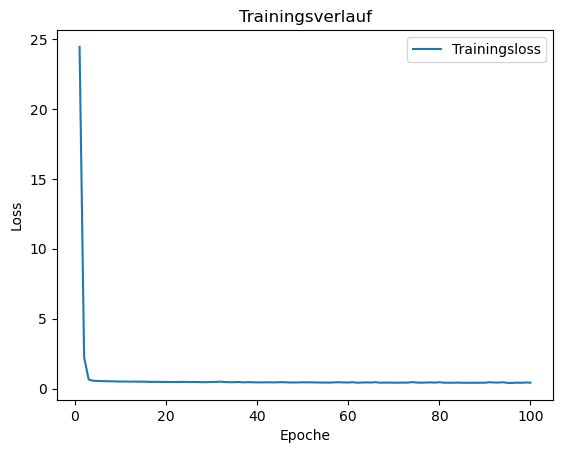

In [100]:
fig, ax = plt.subplots()
ax.plot(range(1, num_epochs + 1), train_losses, label="Trainingsloss")
ax.set_xlabel("Epoche")
ax.set_ylabel("Loss")
ax.set_title("Trainingsverlauf")
ax.legend()
plt.show()


### Aufgabe 6: Optional: Modell ändern

In der vorherigen Aufgabe haben Sie ein einfaches Feedforward-Netzwerk mit einer versteckten Schicht implementiert. Versuchen Sie nun, die Modellarchitektur zu ändern. Sie können z.B. weitere versteckte Schichten hinzufügen, die Anzahl der Neuronen pro Schicht ändern oder andere Aktivierungsfunktionen ausprobieren. Trainieren Sie das verbesserte Modell erneut und vergleichen Sie die Testergebnisse mit dem ursprünglichen Modell.

In [101]:
# TODO Verbessertes Modell erstellen und testen
improved_model = torch.nn.Sequential(
    torch.nn.Linear(11, 50),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(50, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 1)
)
improved_model.to(device)
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)
improved_train_losses = train_model(improved_model, train_loader, loss_function, improved_optimizer, num_epochs)
average_test_loss_improved = test_model(improved_model, test_loader, loss_function)
print(f"Final training loss of improved model: {improved_train_losses[-1]}")

Final training loss of improved model: 0.42693001476296205
